<a href="https://colab.research.google.com/github/salma71/Projects_in_datascience/blob/master/MRI_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #library to upload files to colab notebook
%matplotlib inline

In [4]:
%cd /content/drive/MyDrive/Brain_MRI

/content/drive/MyDrive/Brain_MRI


In [5]:
brain_df = pd.read_csv('data_mask.csv')

In [7]:
brain_df.head(10)

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0
5,TCGA_CS_5395_19981004,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_1_...,0
6,TCGA_CS_5395_19981004,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1.tif,TCGA_CS_4942_19970222/TCGA_CS_4942_19970222_1_...,0
7,TCGA_CS_5395_19981004,TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1.tif,TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_1_...,0
8,TCGA_CS_5395_19981004,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1.tif,TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1_...,0
9,TCGA_CS_5395_19981004,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1.tif,TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_1_...,0


In [9]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [12]:
# check data set balance
brain_df['mask'].value_counts() 

0    2556
1    1373
Name: mask, dtype: int64

In [13]:
1373/(2556+1373)

0.3494527869686943

unbalanced datasets.

In [15]:
brain_df['mask'].value_counts().index.  # to get how many levels I have

Int64Index([0, 1], dtype='int64')

In [19]:
#plot how many samples do I have from healthy samples
import plotly.graph_objects as go

fig = go.Figure([
                 go.Bar(
                     x = brain_df['mask'].value_counts().index,
                     y = brain_df['mask'].value_counts()
                 )
])

fig.update_traces(
    marker_color = 'rgb(0,200,0)',
    marker_line_color = 'rgb(255,0,0)',
    marker_line_width = 3,
    opacity = 0.6
)

fig.show()

In [20]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [21]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

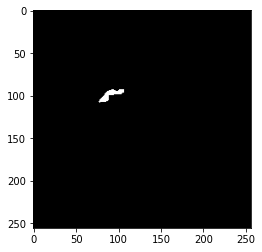

In [22]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

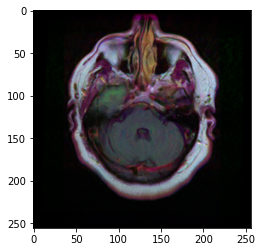

In [23]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

In [25]:
cv2.imread(brain_df.mask_path[623]).max()

255

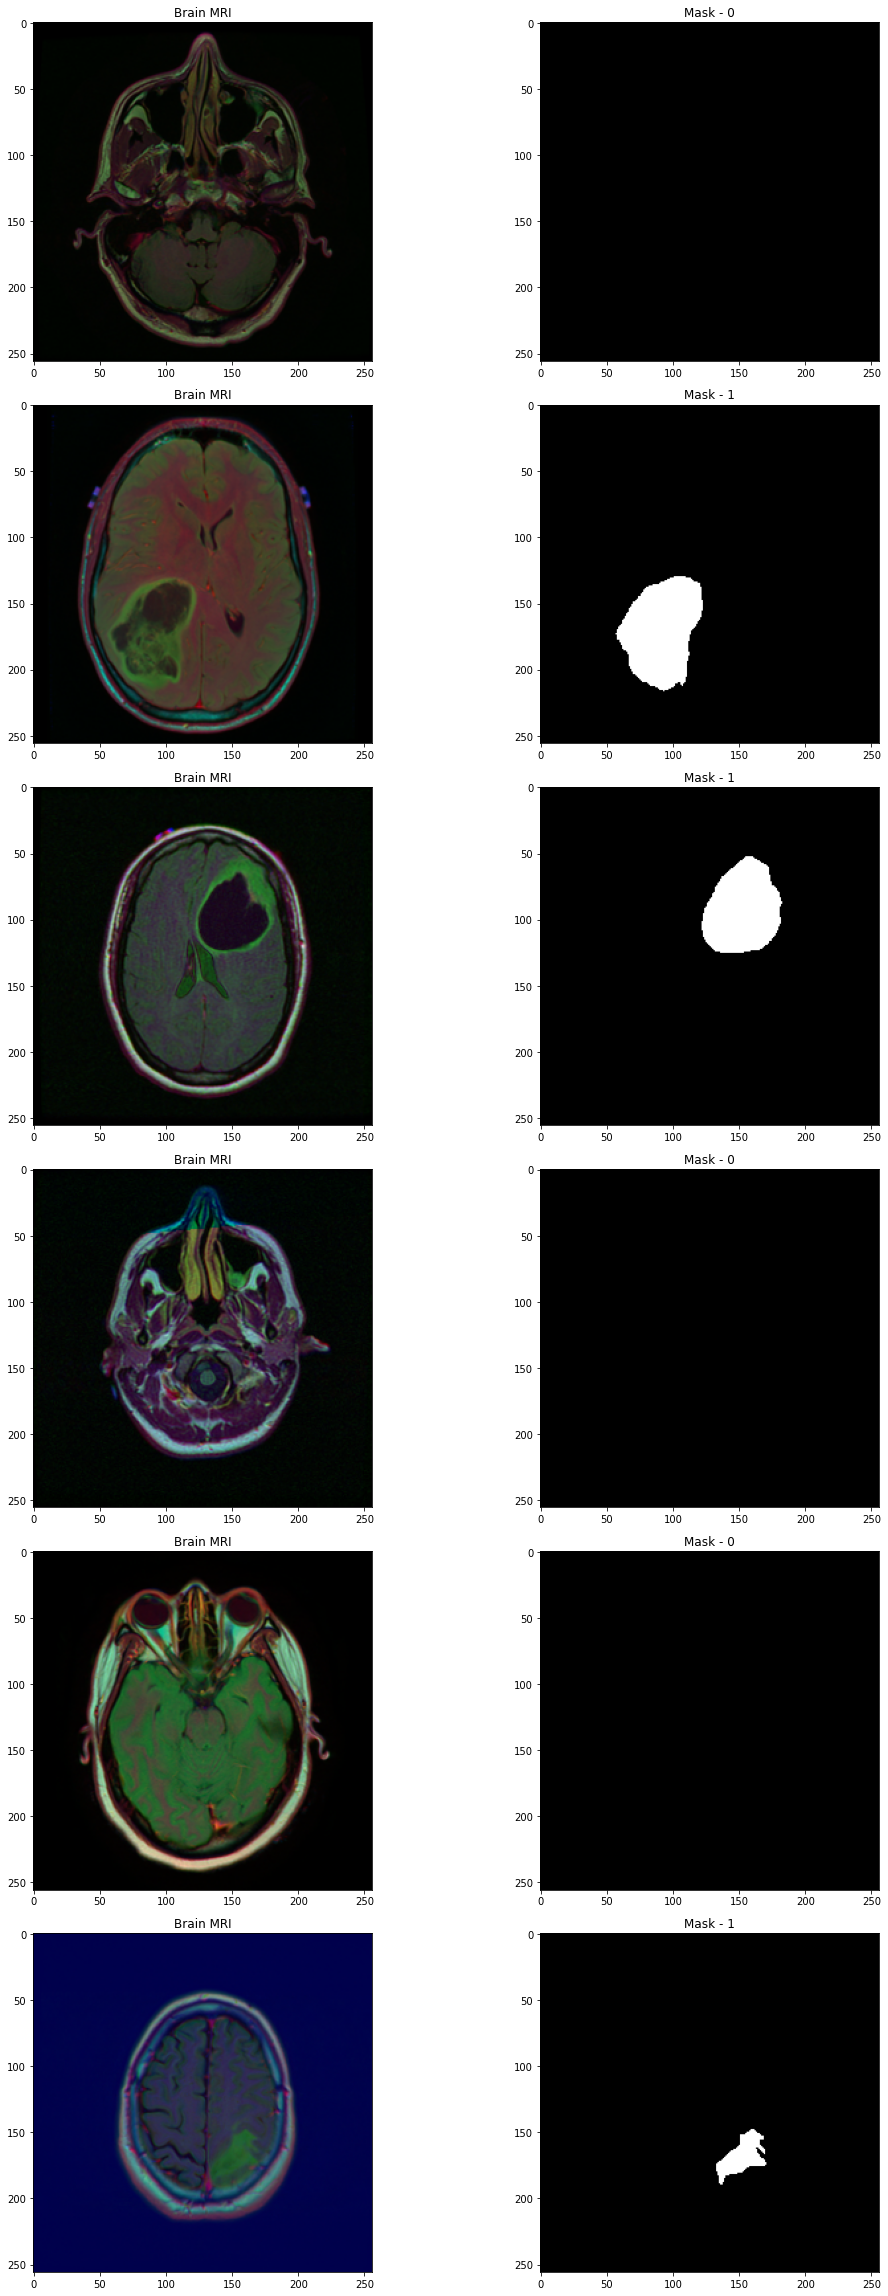

In [27]:
# visualizing the image and it's mask
import random
fig, axs = plt.subplots(6, 2, figsize = (16, 32))
count = 0

for x in range(6):
  i = random.randint(0, len(brain_df))
  axs[count][0].title.set_text("Brain MRI")
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i]))
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i]))
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))
  count += 1

fig.tight_layout()

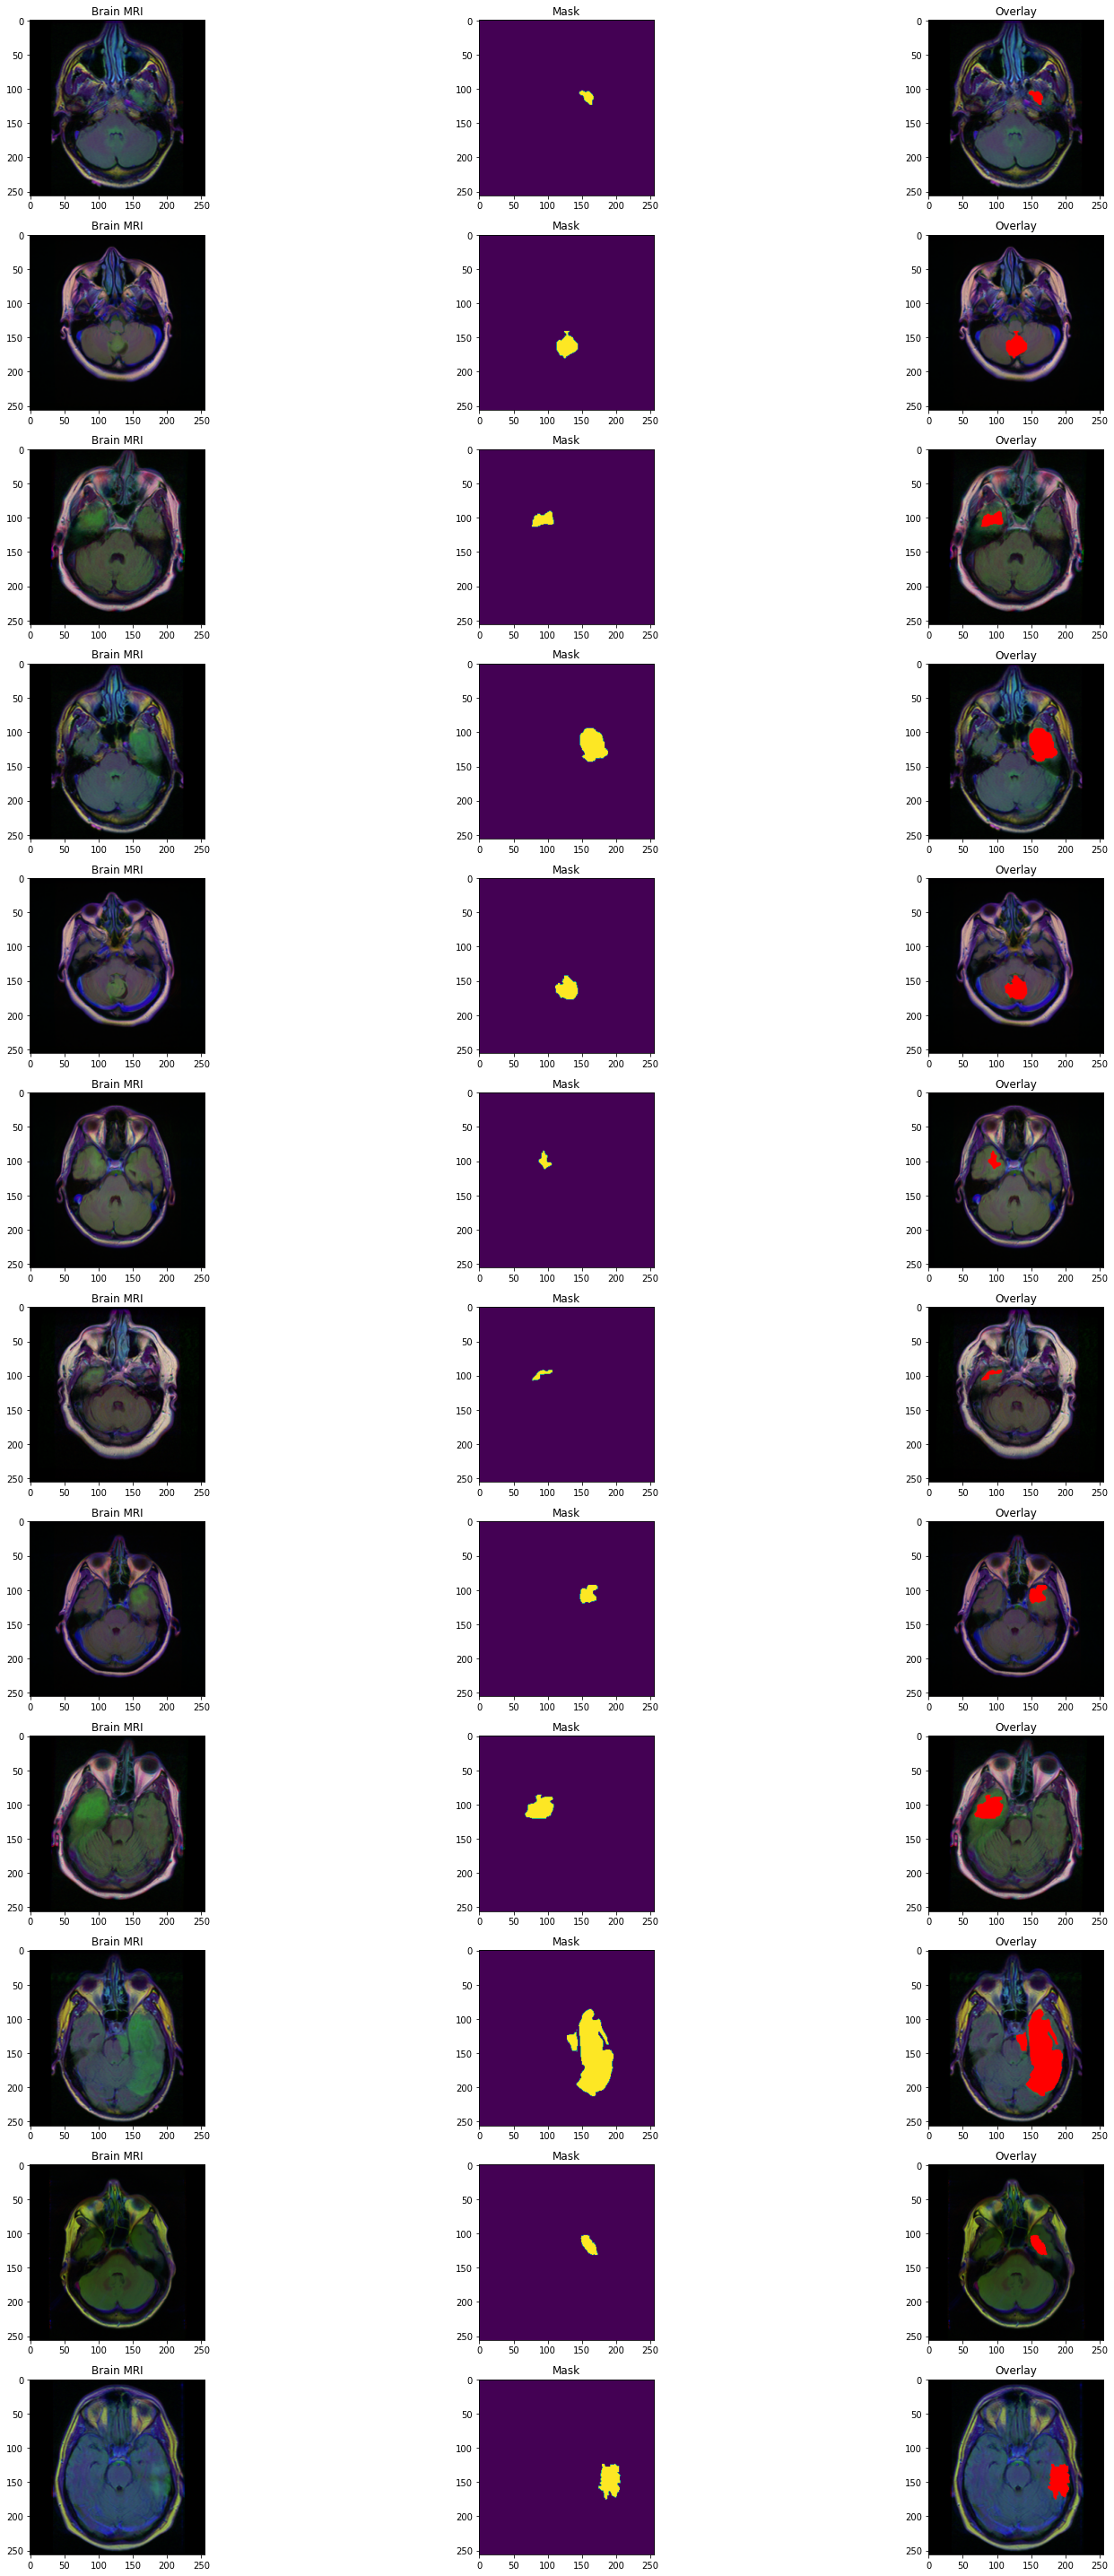

In [30]:
# visualizing the image and it's mask
fig, axs = plt.subplots(12, 3, figsize = (24, 40))
count = 0

for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('Brain MRI')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Mask')
    axs[count][1].imshow(mask)

    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('Overlay')
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()

In [28]:
brain_df[brain_df['mask'] == 1]

,patient_id,image_path,mask_path,mask
445,TCGA_DU_5872_19950223,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5_...,1
507,TCGA_DU_5874_19950510,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5_...,1
551,TCGA_DU_5854_19951104,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6_...,1
555,TCGA_DU_5854_19951104,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6.tif,TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6_...,1
617,TCGA_DU_5853_19950823,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6.tif,TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_...,1
...,...,...,...,...
3785,TCGA_HT_7684_19950816,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_56...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_56...,1
3795,TCGA_HT_7684_19950816,TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_57...,TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_57...,1
3797,TCGA_HT_7684_19950816,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_57...,TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_57...,1
3806,TCGA_HT_7684_19950816,TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58...,TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58...,1
